# SyriaTel Customer Churn
Author: Pharoah Evelyn

![Cellphones](./images/best-smartphones-1633617785.jpeg)

# Overview

#### The Goal of this notebook is to predict when a customer will stop contiuing their service with SyriaTel

In this notebook we will discover which features we can use to predict what will determine if a customer stops their service or not.

We accomplish this by approaching it as a classification probblem, and employ various machine learning algorhithms to provide insights.

# Importing necessary packages

In [1]:
# Importing necessary packages

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid')

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,\
        AdaBoostClassifier, GradientBoostingClassifier

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, plot_confusion_matrix,precision_score,\
        recall_score, accuracy_score, f1_score, log_loss, roc_curve,\
        auc, roc_auc_score, classification_report, plot_roc_curve, mean_absolute_error, mean_squared_error

from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier , DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore') #ignore warning messages 

## Defining Useful Functions

In [2]:
# Defining a function to define metrics of each model
def display_metrics(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    pre = precision_score(true, preds)
    rec = recall_score(true, preds)
    print('Model: {}'.format(model_name))
    print('Precision: {}'.format(pre))
    print('Recall: {}'.format(rec))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
# Defining a function to print out Mean Absolute Error, & Root Mean Squared Error
def find_errors(y_test, preds):
    # Evaluate these predictions
    print('Mean Absolute Error:', mean_absolute_error(y_test, preds)) 
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, preds)))
    
# Defining a function to return a Classification Report as a dataframe. Ease of Reading
metrics_df = []
def get_classification_report(y_test, y_pred):
    from sklearn import metrics
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    
    ##### reindex or change the order of rows
    df_classification_report.reindex(['0', '1', 'accuracy', 'weighted avg', 'macro avg'])
    
    #### Returning Capitalized column names
    df_classification_report.columns = df_classification_report.columns.str.capitalize()

    # Creates a 3-D dataframe
    metrics_df.append(df_classification_report.iloc[1:2, :])
    return df_classification_report

# Returns the feature importances of a model
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    
# Prints the metrics of a model in short-form
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

# Dataset Source
https://www.kaggle.com/becksddf/churn-in-telecoms-dataset

In [3]:
# Importing our data
df = pd.read_csv("data/bigml_59c28831336c6604c800002a.csv")
df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


# Data Investigation

Since this is a classification problem, we need to do some data investigation to discover which features we can investigate for our models

In [4]:
# Obtain a snapshot of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [5]:
# Preview the size of the data
df.shape

(3333, 21)

In [6]:
# Print the summary stats of all columns
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [7]:
# Find the number of missing values in each column
df.isna().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

## Identifying the Target

SyriaTel wis concerned about customer churn. Thus, we can use it as a target variable

In [8]:
df["churn"] = df["churn"].astype(int)
target = 'churn'

#### Addressing Class Imbalance

0    2850
1     483
Name: churn, dtype: int64


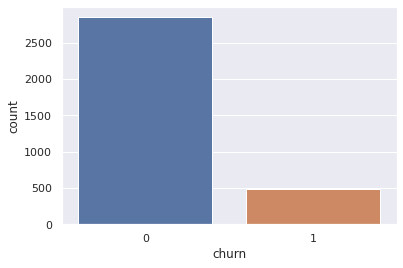

In [9]:
# Looking at the Class distributions in detail
ax = sns.countplot(x=df[target])
print(df[target].value_counts())

In [10]:
# Percentage of positive churn results in total
100* (483/float(df.shape[0]))

14.491449144914492

In [11]:
# Percentage of negative churn results in total
100* (2850/float(df.shape[0]))

85.5085508550855

### Undersampling
Since we have a class imbalance issue, we need to have our samples match in size. This way our models can properly learn the data instead of defaulting to the majority class

In [12]:
# Getting the length of our minority class (Class 1)
minority_class_len = len(df[df[target] == 1])
print(minority_class_len)

483


In [13]:
# Captures wherever Class 0 appears in the original dataframe
majority_class_indices = df[df[target] == 0].index
print(majority_class_indices)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3321, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332],
           dtype='int64', length=2850)


In [14]:
# Randomly selecting samples from our majority class, using numpy
random_majority_indices = np.random.choice(majority_class_indices, # Selecting the Majority Class Indices
                                           minority_class_len, # Specifying the number of samples needed, 
                                                               # with our minority_class_len
                                           replace = False) # & We do not want any samples to get replaced, 
                                                            # ensuring unique replacements

# Verifying the length matches the minority class
print(len(random_majority_indices))

483


In [15]:
# Captures wherever Class 1 appears in the original dataframe
minority_class_indices = df[df[target] == 1].index
print(minority_class_indices)

Int64Index([  10,   15,   21,   33,   41,   48,   54,   57,   69,   76,
            ...
            3268, 3272, 3280, 3287, 3291, 3301, 3304, 3320, 3322, 3323],
           dtype='int64', length=483)


In [16]:
# Concatenating majority & minority indices
under_sample_indices = np.concatenate([minority_class_indices, random_majority_indices])

In [17]:
# Creating a dataframe from the concatenation
under_sample = df.loc[under_sample_indices]

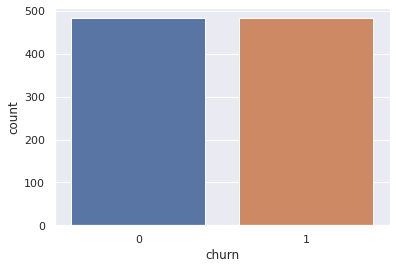

In [18]:
# Looking at the Class distributions in detail
ax = sns.countplot(x=target, data=under_sample)

In [19]:
# Removing the target & unuseful columns from our X axis
X = under_sample.loc[:, df.columns!=target]
X = X.drop(["state", "area code", "phone number"], axis=1, inplace=False)
# Getting our categorical variables
X = pd.get_dummies(X)
X = X.drop(["international plan_no", "voice mail plan_no"], axis =1, inplace=False)

# Selecting the target for the y axis
# Transforming our target into categorical variables
y = under_sample.loc[:, df.columns==target]

X.head()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,international plan_yes,voice mail plan_yes
10,65,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,0,0
15,161,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,0,0
21,77,0,62.4,89,10.61,169.9,121,14.44,209.6,64,9.43,5.7,6,1.54,5,0,0
33,12,0,249.6,118,42.43,252.4,119,21.45,280.2,90,12.61,11.8,3,3.19,1,0,0
41,135,41,173.1,85,29.43,203.9,107,17.33,122.2,78,5.50,14.6,15,3.94,0,1,1


In [20]:
# Checking our target values
y.nunique()

churn    2
dtype: int64

In [21]:
# Further detail on our target values
# Verifying our value counts are equal for each class
y.value_counts()

churn
0        483
1        483
dtype: int64

### Feature Selection Refinement

Here, we're using Scikit Learn's RFE package in order to determine which features are the most relevant for our purposes.

We will refine the features down to 10.

In [22]:
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=10, step=1, importance_getter='auto')
rfe_selector.fit(X, y)

# The best set of features that are selcted, denoted as True, False
print(rfe_selector.support_)
# All selected features are marked 1, the unselected redundant features ranked in increasing order
print(rfe_selector.ranking_)

# Get a mask, or integer index, of the features selected
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

[False  True  True False False False  True False False  True False  True
  True  True  True  True  True]
[5 1 1 4 3 2 1 7 6 1 8 1 1 1 1 1 1]
10 selected features


In [23]:
# Viewing which additional columns would need to be removed
X.columns

Index(['account length', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls',
       'international plan_yes', 'voice mail plan_yes'],
      dtype='object')

In [24]:
# Dropping columns recommended by our RFE Selector
X = X.drop(['account length', 'total day charge', 'total eve minutes',
        'total eve charge', 'total night minutes', 
        'total night charge', 'total intl charge'], axis = 1, inplace=False)

### Train & Test Split

Having a train test split is important because it allows us to train our models with bits & pieces of the data, and test it on the remainder.

In [25]:
# Create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# And now, we begin modeling our data!
![Math](./images/AdobeStock_300175055-scaled.jpeg)

# Logistic Regression

In [26]:
# Scale the data for modeling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [27]:
#### Beginning the Logistic Regression

# Train a logistic regresssion model with the train data
lr_model = LogisticRegression(random_state=42, class_weight='balanced')
lr_model.fit(X_train_sc, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [28]:
# '.score' Prints the accuracy of a model
lr_model.score(X_test_sc, y_test)

0.7768595041322314

### Classification Metrics

#### Making Predictions & Calculating the MAE and RMSE

- MAE: Mean Absolute Error - Mean of prediction errors across a regression model 
- RMSE: Root Mean Squared Error - The measure of how well a regression line fits the data points.

The lower, the better!

#### Classification Report
A table in which the Accuract, Precision, Recall, & F1 scores are returned

#### Confusion Matrix
A visual representation of how our model correctly predicts whether or not a customer will stop doing business with SyriaTel

#### The Receiver Operating Characteristic (ROC) Curve
Plotting the true-positive rate vs the false-positive rate.
Area Under the Curve (AUC) is a score between 0 & 1
* Any Score at 0.5 &. below is useless


In [29]:
# A standard Confusion Matrix
y_pred = lr_model.predict(X_test_sc)
cm_1 = confusion_matrix(y_test, y_pred)
cm_1

array([[99, 24],
       [30, 89]])

Mean Absolute Error: 0.2231404958677686
Root Mean Squared Error: 0.4723774929733302


,Precision,Recall,F1-score,Support
0,0.767442,0.804878,0.785714,123.00000
1,0.787611,0.747899,0.767241,119.00000
accuracy,0.776860,0.776860,0.776860,0.77686
macro avg,0.777526,0.776389,0.776478,242.00000
weighted avg,0.777360,0.776860,0.776631,242.00000


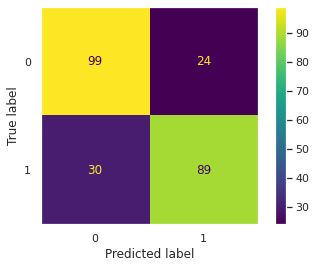

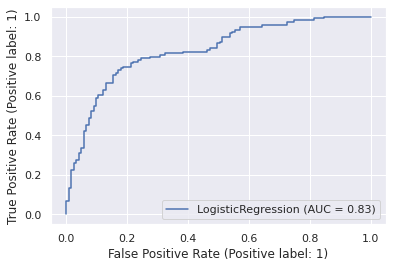

In [30]:
# More visual representation of a confusion Matrix
plot_confusion_matrix(lr_model, X_test_sc, y_test);    
plt.grid(False)

# Prints the MAE & RMSE of a model
find_errors(y_test, y_pred)

# Plots the ROC Curve & Returns the AUC score
plot_roc_curve(lr_model, X_test_sc, y_test);

# Returns a Classification Report of a model, as a dataframe
get_classification_report(y_test, y_pred)

#### Interpretation of churn with a vanilla LR Model:
* 99 True Negatives: Customers continue service with SyriaTel
* 24 False Positives: The model believes customers will continue service with SyriaTel, but they do not
* 30 False Negatives: The model believes customers will not continue service with SyriaTel, but they do
* 89 True Positives: Customers do not continue service with SyriaTel

We need to investigate further to see if this is a good model or not

## Overall, we want to minimize the ammount of False Negatives

### Experimenting with the class imbalance further

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Text(0.5, 1.0, 'Scoring for Different Class Weights')

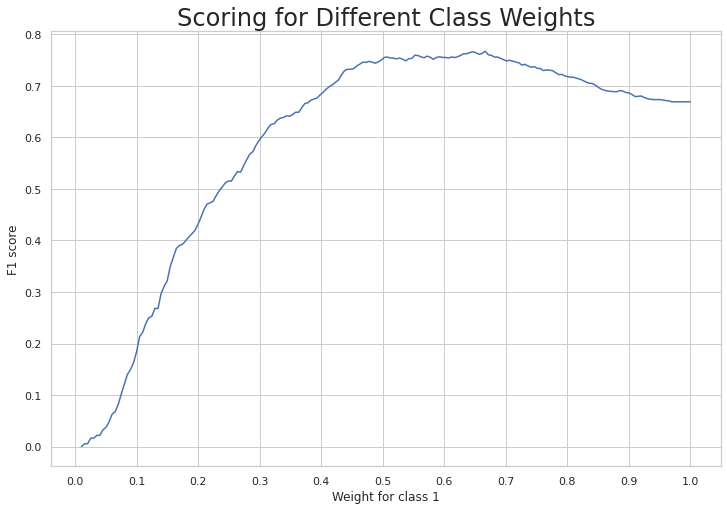

In [31]:
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
lrgridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=1).fit(X_train_sc, y_train.values.ravel()) 
                                                    #.values.ravel() kills an error alert
                                                    # A column-vector y was passed when a 1d array was expected

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': lrgridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for Different Class Weights', fontsize=24)

In [32]:
print("Best Score:", lrgridsearch.best_score_,"\n")
print("Best Estimator:", lrgridsearch.best_estimator_,"\n")
print("Best Parameters:", lrgridsearch.best_params_)

Best Score: 0.7674175945173232 

Best Estimator: LogisticRegression(class_weight={0: 0.3333165829145729, 1: 0.6666834170854271},
                   solver='newton-cg') 

Best Parameters: {'class_weight': {0: 0.3333165829145729, 1: 0.6666834170854271}}


#### Above, we can see the results for the best weight for class 1 listed.

Now that we have our best class weights using stratified cross-validation and grid search, we will see the performance on the test data.

Mean Absolute Error: 0.30578512396694213
Root Mean Squared Error: 0.5529784118452927


,Precision,Recall,F1-score,Support
0,0.775281,0.560976,0.650943,123.000000
1,0.647059,0.831933,0.727941,119.000000
accuracy,0.694215,0.694215,0.694215,0.694215
macro avg,0.711170,0.696454,0.689442,242.000000
weighted avg,0.712230,0.694215,0.688806,242.000000


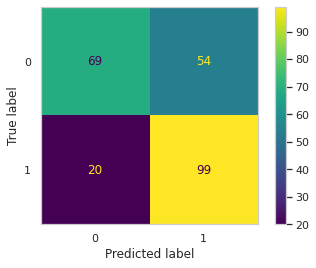

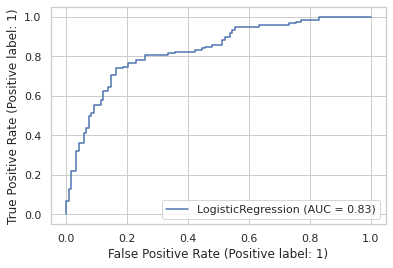

In [33]:
#importing and training the model
lr = lrgridsearch.best_estimator_
lr.fit(X_train_sc, y_train)

# Predicting on the test data
pred_test = lr.predict(X_test_sc)

#Ploting our Classification Metrics
plot_confusion_matrix(lr, X_test_sc, y_test);
plt.grid(False)
find_errors(y_test, pred_test)
plot_roc_curve(lr, X_test_sc, y_test);
get_classification_report(y_test, pred_test)

#### Interpretation of churn with a tuned LR Model:
* 69 True Negatives: Customers continue service with SyriaTel
* 54 False Positives: The model believes customers will continue service with SyriaTel, but they do not
* 20 False Negatives: The model believes customers will not continue service with SyriaTel, but they do
* 99 True Positives: Customers do not continue service with SyriaTel

#### We see a decrease in accuracy of our True Negatives being correctly reported (as well as an increase in False Positives). We also see a higher MAE & RMSE
#### However, our ROC curve performs the same overall

# KNN with scikit-learn
Lets start with scaling our data for KNN (& all future models)

In [34]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_data_train, columns=X.columns)
scaled_df_train.head()

,number vmail messages,total day minutes,total day calls,total eve calls,total night calls,total intl minutes,total intl calls,customer service calls,international plan_yes,voice mail plan_yes
0,-0.529112,0.069937,-0.081540,1.036175,-1.225746,1.948667,-0.942444,-1.164151,-0.463428,-0.551819
1,-0.529112,0.964327,-0.767990,-0.103617,-1.487961,0.259209,0.653648,0.767504,-0.463428,-0.551819
2,-0.529112,1.537121,1.095232,0.725322,0.662201,0.052337,-0.144398,-1.164151,-0.463428,-0.551819
3,-0.529112,-0.730054,0.114589,1.916923,-0.858645,0.052337,-0.144398,-1.164151,-0.463428,-0.551819
4,-0.529112,-0.461257,1.487489,0.103617,0.976859,0.362646,-0.942444,0.123619,2.157835,-0.551819


#### Checking a vanilla KNN Classifier

In [35]:
v_knn = KNeighborsClassifier()
v_knn.fit(scaled_data_train, y_train)

KNeighborsClassifier()

In [36]:
v_knn_preds = v_knn.predict(scaled_data_test)

#### Evaluate on a test set

Mean Absolute Error: 0.1487603305785124
Root Mean Squared Error: 0.38569460791993504


,Precision,Recall,F1-score,Support
0,0.837209,0.878049,0.857143,123.00000
1,0.867257,0.823529,0.844828,119.00000
accuracy,0.851240,0.851240,0.851240,0.85124
macro avg,0.852233,0.850789,0.850985,242.00000
weighted avg,0.851985,0.851240,0.851087,242.00000


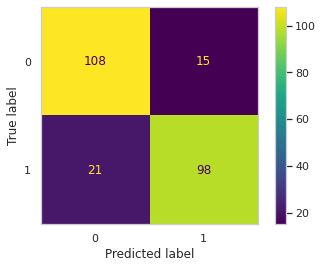

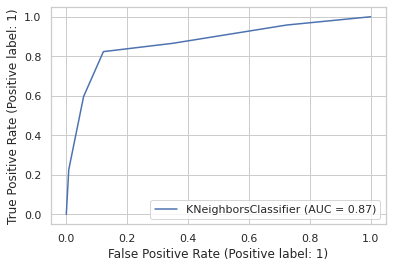

In [37]:
#### Classification Metrics
plot_confusion_matrix(v_knn, scaled_data_test, y_test);
plt.grid(False)
find_errors(y_test, v_knn_preds)
plot_roc_curve(v_knn, scaled_data_test, y_test);
get_classification_report(y_test, v_knn_preds)

#### Interpretation of churn with a vanilla KNN Model:
* 108 True Negatives: Customers continue service with SyriaTel
* 15 False Positives: The model believes customers will continue service with SyriaTel, but they do not
* 22 False Negatives: The model believes customers  will not continue service with SyriaTel, but they do 
* 98 True Positives: Customers do not continue service with SyriaTel

#### Our vanilla KNN Confusion Matrix performs better than our vanilla Logistic Regression. 
#### We also see a lower MAE, RMSE, & a higher AUC score than our Vanilla Logistic Regression Model

### Using Gridsearch to find the best fit using KNN as a predictor
Lets see if we can improve this performance using a gridsearch!

In [38]:
knn = KNeighborsClassifier()

# Testing class weights since our data has a severe class imbalance
param_grid = {
    'n_neighbors': np.arange(1, 101),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
  
# defining parameter range,
grid = GridSearchCV(knn, param_grid, cv=5, verbose=1, n_jobs = -1)
  
# fitting the model for grid search
grid_search=grid.fit(scaled_data_train, y_train.values.ravel())

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


In [39]:
print("Best Score:", grid_search.best_score_,"\n")
print("Best Estimator:", grid_search.best_estimator_,"\n")
print("Best Parameters:", grid_search.best_params_)

Best Score: 0.7997222222222222 

Best Estimator: KNeighborsClassifier(metric='manhattan', n_neighbors=21, weights='distance') 

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'distance'}


In [40]:
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 79.97%


### Fit the KNN Model

In [41]:
# Instantiate KNeighborsClassifier
knn_clf = grid_search.best_estimator_

# Fit the classifier
knn_clf.fit(scaled_data_train, y_train)

# Predict on the test set
knn_clf_preds = knn_clf.predict(scaled_data_test)

#### Evaluate the model  on test set

Mean Absolute Error: 0.1446280991735537
Root Mean Squared Error: 0.38030001206094344


,Precision,Recall,F1-score,Support
0,0.823529,0.910569,0.864865,123.000000
1,0.896226,0.798319,0.844444,119.000000
accuracy,0.855372,0.855372,0.855372,0.855372
macro avg,0.859878,0.854444,0.854655,242.000000
weighted avg,0.859277,0.855372,0.854823,242.000000


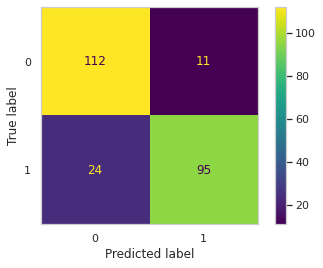

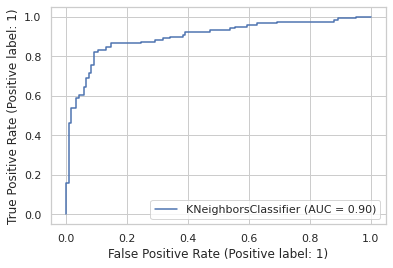

In [42]:
#### Classification Metrics
plot_confusion_matrix(knn_clf, scaled_data_test, y_test);
plt.grid(False)
find_errors(y_test, knn_clf_preds)
plot_roc_curve(knn_clf, scaled_data_test, y_test);
get_classification_report(y_test, knn_clf_preds)

#### Interpretation of churn with a tuned KNN Model:
* 112 True Negatives: Customers continue service with SyriaTel
* 11 False Positives: The model believes customers will continue service with SyriaTel, but they do not
* 24 False Negatives: The model believes customers  will not continue service with SyriaTel, but they do 
* 95 True Positives: Customers do not continue service with SyriaTel

#### We see a slight improvement in our model' performance in True Negatives. Our False Negatives have also lessened, to a degree. We also see a better MAE & RMSE
#### ROC Curve here is better than our vanilla KNN Model

Notably, our Error calculations are marginally higher than our second logistic regression model's.

# Decision Trees
Predicting outcomes using Decision Trees

#### Training a vanilla classifier

In [43]:
vt_clf = DecisionTreeClassifier(criterion='entropy')

vt_clf.fit(scaled_data_train, y_train)

DecisionTreeClassifier(criterion='entropy')

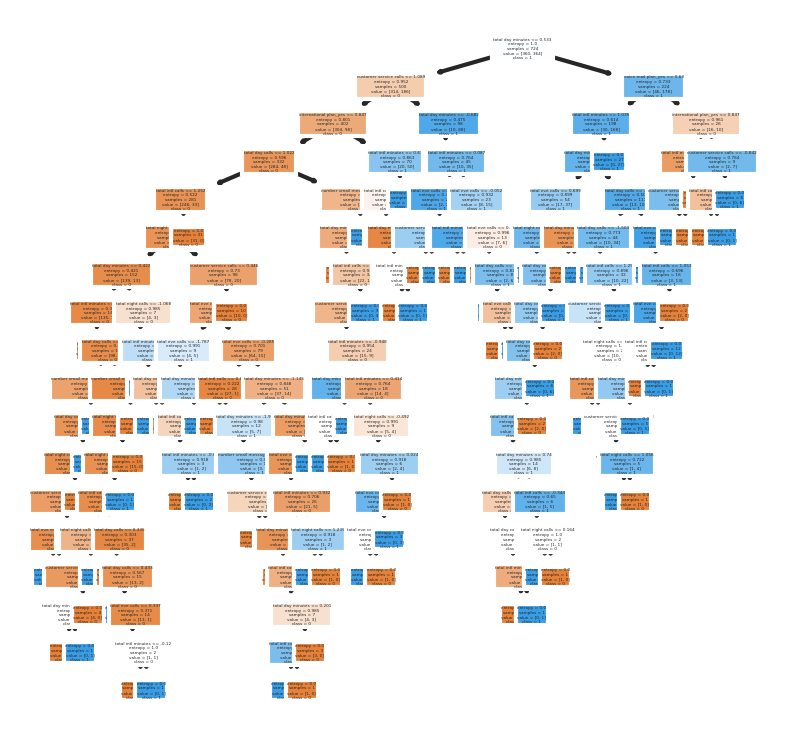

In [44]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
tree.plot_tree(vt_clf,
               feature_names = X_train.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()

#### Evaluating predictve performance

In [45]:
vt_preds = vt_clf.predict(scaled_data_test)

Mean Absolute Error: 0.2024793388429752
Root Mean Squared Error: 0.4499770425732575


,Precision,Recall,F1-score,Support
0,0.808333,0.788618,0.798354,123.000000
1,0.786885,0.806723,0.796680,119.000000
accuracy,0.797521,0.797521,0.797521,0.797521
macro avg,0.797609,0.797670,0.797517,242.000000
weighted avg,0.797787,0.797521,0.797531,242.000000


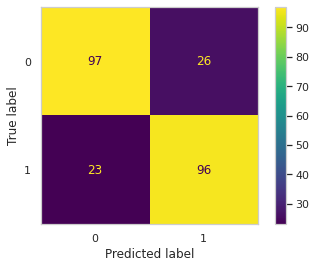

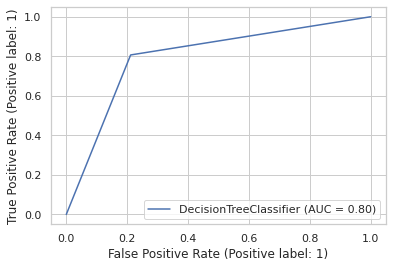

In [46]:
#### Classification Metrics
plot_confusion_matrix(vt_clf, scaled_data_test, y_test);
plt.grid(False)
find_errors(y_test, vt_preds)
plot_roc_curve(vt_clf, scaled_data_test, y_test);
get_classification_report(y_test, vt_preds)

#### Interpretation of churn with a vanilla Decision Tree:
* 97 True Negatives: Customers continue service with SyriaTel
* 26 False Positives: The model believes customers will continue service with SyriaTel, but they do not
* 23 False Negatives: The model believes customers  will not continue service with SyriaTel, but they do 
* 96 True Positives: Customers do not continue service with SyriaTel

#### This model overall does not perform as well as our second KNN Model, as Precision & Recall are lower. Error Metrics have also increased a bit.

#### Despite it predicting less False Negatives, our AUC score has dipped, compared to our tuned KNN Model

#### Feature Importance

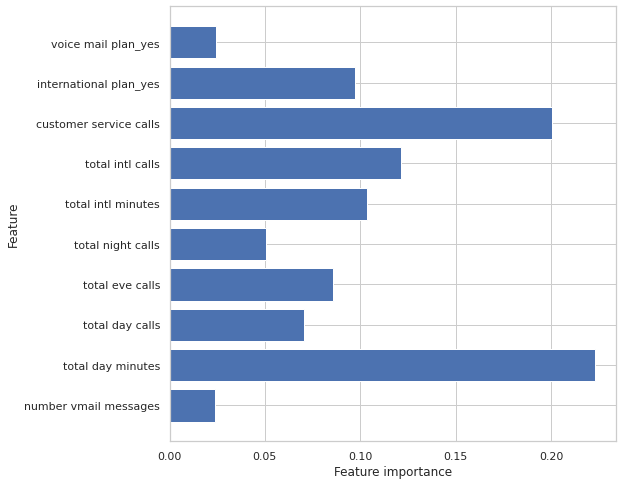

In [47]:
plot_feature_importances(vt_clf)

### Hyper Parameter tuning our Decision Tree

In [48]:
tree_clf = DecisionTreeClassifier(random_state=42)

tree_param_grid = { 
    'criterion' :['gini', 'entropy'],
    'max_features': np.arange(1, 11),
    'max_depth' : np.arange(1, 11),
    'min_samples_split' : np.linspace(0.1, 1.0, 10, endpoint=True),
    'min_samples_leaf' : np.linspace(0.01, 0.06, 5, endpoint=True)
}

# Instantiate GridSearchCV
tree_grid_search = GridSearchCV(tree_clf, tree_param_grid, cv=5, return_train_score=True, verbose = 1)

# Fit to the data
tree_grid_search.fit(scaled_data_train, y_train)

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'min_samples_leaf': array([0.01  , 0.0225, 0.035 , 0.0475, 0.06  ]),
                         'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             return_train_score=True, verbose=1)

#### Examining the best parameters

In [49]:
print("Best Score:", tree_grid_search.best_score_,"\n")
print("Best Estimator:", tree_grid_search.best_estimator_,"\n")
print("Best Parameters:", tree_grid_search.best_params_)

Best Score: 0.8438888888888888 

Best Estimator: DecisionTreeClassifier(max_depth=3, max_features=5, min_samples_leaf=0.01,
                       min_samples_split=0.2, random_state=42) 

Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 0.01, 'min_samples_split': 0.2}


In [50]:
dt_clf = tree_grid_search.best_estimator_

# Train a classifier with optimal values identified above
dt_clf.fit(scaled_data_train, y_train)
dt_pred = dt_clf.predict(scaled_data_test)

Mean Absolute Error: 0.1446280991735537
Root Mean Squared Error: 0.38030001206094344


,Precision,Recall,F1-score,Support
0,0.872881,0.837398,0.854772,123.000000
1,0.838710,0.873950,0.855967,119.000000
accuracy,0.855372,0.855372,0.855372,0.855372
macro avg,0.855796,0.855674,0.855369,242.000000
weighted avg,0.856078,0.855372,0.855360,242.000000


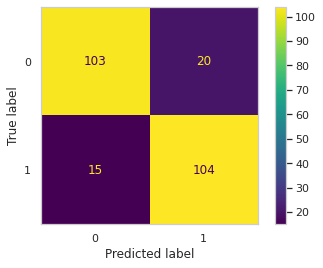

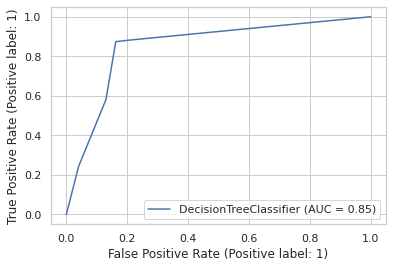

In [51]:
#### Classification Metrics
plot_confusion_matrix(dt_clf, scaled_data_test, y_test);
plt.grid(False)
find_errors(y_test, dt_pred)
plot_roc_curve(dt_clf, scaled_data_test, y_test);
get_classification_report(y_test, dt_pred)

#### Interpretation of churn with Tuned Decision Tree:
* 103 True Negatives: Customers continue service with SyriaTel
* 20 False Positives: The model believes customers will continue service with SyriaTel, but they do not
* 15 False Negatives: The model believes customers  will not continue service with SyriaTel, but they do 
* 104 True Positives: Customers do not continue service with SyriaTel

#### This model shows a nice reduction in reported False Negatives.

#### In addition to predicting less False Negatives, our ROC Curve is up compared to our vanilla Decision Tree
Error Metrics are lower as well.

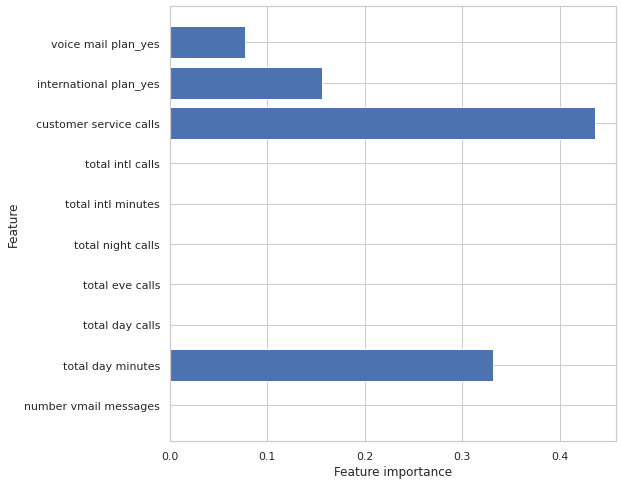

In [52]:
# Feature Importances
plot_feature_importances(dt_clf)

# Regression with CART Trees

In this model, we shall see how regression is performed in using a decision tree regressor with our data

In [53]:
# Instantiate and fit a regression tree model to training data 
regressor = DecisionTreeRegressor(random_state=42)  
regressor.fit(scaled_data_train, y_train)  

DecisionTreeRegressor(random_state=42)

In [54]:
# Make predictions on the test set
cart_pred = regressor.predict(scaled_data_test)

In [55]:
find_errors(y_test, cart_pred)
print_metrics(y_test, cart_pred)

Mean Absolute Error: 0.21074380165289255
Root Mean Squared Error: 0.4590684062891853
Precision Score: 0.7698412698412699
Recall Score: 0.8151260504201681
Accuracy Score: 0.7892561983471075
F1 Score: 0.7918367346938775


#### Interpretation of churn with CART Trees:
* Really low error scores suggest that our model is performing very well.
* Our Precision & Recall scores here are polar, and the over Accuracy Score has dipped to below 62%

# Tree Ensembles and Random Forests

In [56]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(scaled_data_train, y_train)

RandomForestClassifier(max_depth=5)

In [57]:
# Training accuracy score
forest.score(scaled_data_train, y_train)
forest_preds=forest.predict(scaled_data_test)

In [58]:
# Test accuracy score
forest.score(scaled_data_test, y_test)

0.859504132231405

Mean Absolute Error: 0.14049586776859505
Root Mean Squared Error: 0.37482778414706003


,Precision,Recall,F1-score,Support
0,0.867769,0.853659,0.860656,123.000000
1,0.851240,0.865546,0.858333,119.000000
accuracy,0.859504,0.859504,0.859504,0.859504
macro avg,0.859504,0.859602,0.859495,242.000000
weighted avg,0.859641,0.859504,0.859514,242.000000


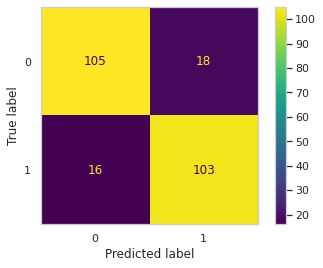

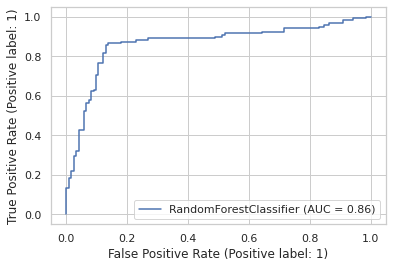

In [59]:
#### Classification Metrics
plot_confusion_matrix(forest, scaled_data_test, y_test);
plt.grid(False)
find_errors(y_test, forest_preds)
plot_roc_curve(forest, scaled_data_test, y_test);
get_classification_report(y_test, forest_preds)

#### Interpretation of churn with a Vanilla Forest:
* 105 True Negatives: Customers continue service with SyriaTel
* 18 False Positives: The model believes customers will continue service with SyriaTel, but they do not
* 16 False Negatives: The model believes customers  will not continue service with SyriaTel, but they do 
* 103 True Positives: Customers do not continue service with SyriaTel

#### This model performs simillarly, but slightly better than the tuned Decision Tree overall.

Our Error calculations here also preform better than our tuned Decision Tree

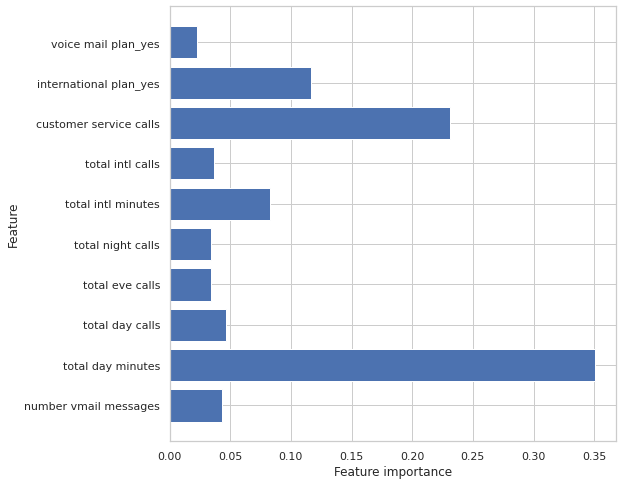

In [60]:
# Feature Importance
plot_feature_importances(forest)

In [61]:
# Instantiate and fit a RandomForestClassifier
forest_2 = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
forest_2.fit(scaled_data_train, y_train)

RandomForestClassifier(max_depth=2, max_features=10, n_estimators=5)

In [62]:
# First tree from forest_2
rf_tree_1 = forest_2.estimators_[0]

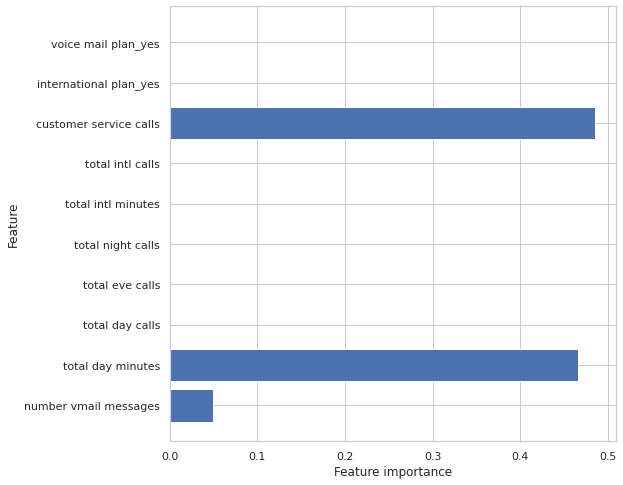

In [63]:
# Feature importance
plot_feature_importances(rf_tree_1)

In [64]:
# Training accuracy score
forest_2.score(scaled_data_train, y_train)

0.7886740331491713

In [65]:
# Test accuracy score
forest_2.score(scaled_data_test, y_test)

0.7396694214876033

### Gridsearch with Random Forests

In [66]:
rf_clf = RandomForestClassifier(random_state=42)

rf_param_grid = { 
    'n_estimators': [100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(1, 27),
    'criterion' :['gini', 'entropy']
}

# Instantiate GridSearchCV
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=5, return_train_score=True, verbose = 1)

# Fit to the data
rf_grid_search.fit(scaled_data_train, y_train)

Fitting 5 folds for each of 156 candidates, totalling 780 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26]),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100]},
             return_train_score=True, verbose=1)

#### Examining the best parameters

In [67]:
print("Best Score:", rf_grid_search.best_score_,"\n")
print("Best Estimator:", rf_grid_search.best_estimator_,"\n")
print("Best Parameters:", rf_grid_search.best_params_)

Best Score: 0.8508141762452108 

Best Estimator: RandomForestClassifier(criterion='entropy', max_depth=4, random_state=42) 

Best Parameters: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}


In [68]:
best_forest = rf_grid_search.best_estimator_

#repeating steps for fitting a model & achiving its scores
best_forest.fit(scaled_data_train, y_train)
best_forest

# Training accuracy score
best_forest.score(X_train, y_train)
bf_preds=best_forest.predict(X_test)

In [69]:
# Test accuracy score
best_forest.score(scaled_data_test, y_test)

0.859504132231405

Mean Absolute Error: 0.5082644628099173
Root Mean Squared Error: 0.712926688243551


,Precision,Recall,F1-score,Support
0,0.000000,0.000000,0.000000,123.000000
1,0.491736,1.000000,0.659280,119.000000
accuracy,0.491736,0.491736,0.491736,0.491736
macro avg,0.245868,0.500000,0.329640,242.000000
weighted avg,0.241804,0.491736,0.324191,242.000000


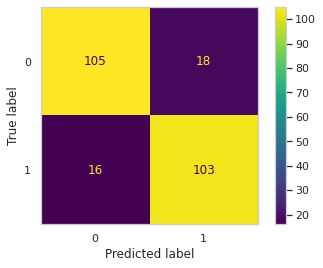

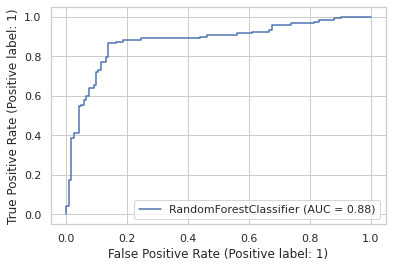

In [70]:
#### Classification Metrics
plot_confusion_matrix(best_forest, scaled_data_test, y_test);
plt.grid(False)
find_errors(y_test, bf_preds)
plot_roc_curve(best_forest, scaled_data_test, y_test);
get_classification_report(y_test, bf_preds)

#### Interpretation of churn with a Tuned Forest:
* 105 True Negatives: Customers continue service with SyriaTel
* 18 False Positives: The model believes customers will continue service with SyriaTel, but they do not
* 16 False Negatives: The model believes customers  will not continue service with SyriaTel, but they do 
* 103 True Positives: Customers do not continue service with SyriaTel

#### Our error calculations are much higher than our Vanilla Forest as well, which is not necessarily good. The classification report is very skewed as well

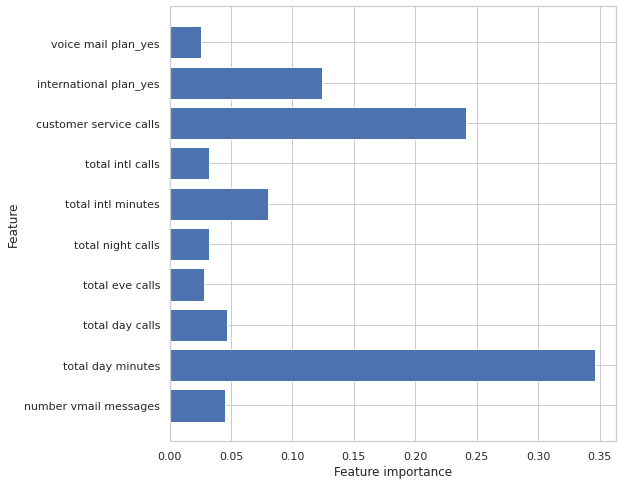

In [71]:
plot_feature_importances(best_forest)

# Support Vector Machines

Vanilla classifier

In [72]:
# Classifier training using vanilla Support Vector Machine 
svm_clf = SVC()
svm_clf.fit(scaled_data_train,y_train)

SVC()

In [73]:
# Testing the classifier's accuracy
svm_clf.score(scaled_data_test,y_test)

0.859504132231405

Mean Absolute Error: 0.14049586776859505
Root Mean Squared Error: 0.37482778414706003


,Precision,Recall,F1-score,Support
0,0.873950,0.845528,0.859504,123.000000
1,0.845528,0.873950,0.859504,119.000000
accuracy,0.859504,0.859504,0.859504,0.859504
macro avg,0.859739,0.859739,0.859504,242.000000
weighted avg,0.859974,0.859504,0.859504,242.000000


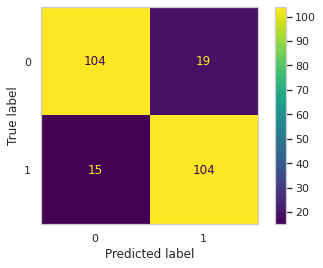

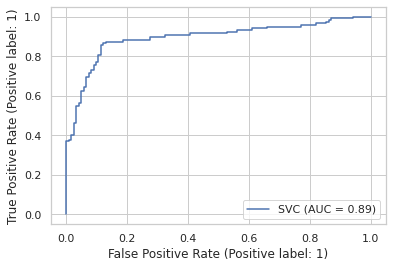

In [74]:
# Classification Metrics
svm_preds = svm_clf.predict(scaled_data_test)

plot_confusion_matrix(svm_clf, scaled_data_test, y_test);
plt.grid(False)
find_errors(y_test, svm_preds)
plot_roc_curve(svm_clf, scaled_data_test, y_test);
get_classification_report(y_test, svm_preds)

#### Interpretation of churn with a Vanilla SVM:
* 104 True Negatives: Customers continue service with SyriaTel
* 19 False Positives: The model believes customers will continue service with SyriaTel, but they do not
* 15 False Negatives: The model believes customers  will not continue service with SyriaTel, but they do 
* 104 True Positives: Customers do not continue service with SyriaTel

#### This model performs very well at predicting True Positives & Negatives, with having among the highest ROC Curves seen so far, & lower False Negative occurences
#### Our Error calculations perform very good as well

#### Searching for best parameters in SVM using GridSearch

In [75]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid'],
             'class_weight':['balanced', None]}
 
svm_grid = GridSearchCV(SVC(), param_grid, cv=5, refit = True, verbose = 1)
 
# fitting the model for grid search
svm_grid.fit(scaled_data_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', None],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid']},
             verbose=1)

In [76]:
print("Best Score:", svm_grid.best_score_,"\n")
print("Best Estimator:", svm_grid.best_estimator_,"\n")
print("Best Parameters:", svm_grid.best_params_)

Best Score: 0.8065804597701149 

Best Estimator: SVC(C=1, class_weight='balanced', gamma=0.1) 

Best Parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


In [77]:
best_svm = svm_grid.best_estimator_

#repeating steps for fitting a model & achiving its scores
best_svm.fit(scaled_data_train, y_train)
best_svm_preds = best_svm.predict(scaled_data_test)

# Training accuracy score
best_svm.score(scaled_data_test, y_test)

0.8636363636363636

Mean Absolute Error: 0.13636363636363635
Root Mean Squared Error: 0.3692744729379982


,Precision,Recall,F1-score,Support
0,0.875000,0.853659,0.864198,123.000000
1,0.852459,0.873950,0.863071,119.000000
accuracy,0.863636,0.863636,0.863636,0.863636
macro avg,0.863730,0.863804,0.863634,242.000000
weighted avg,0.863916,0.863636,0.863643,242.000000


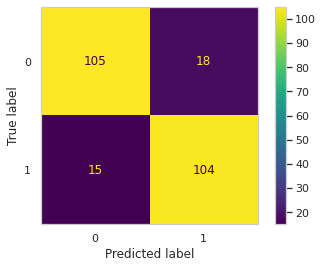

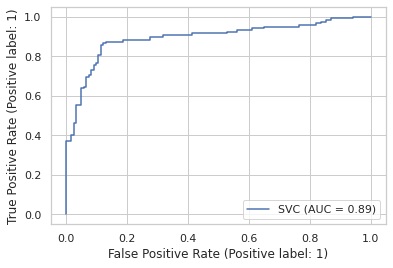

In [78]:
# Classification Metrics
plot_confusion_matrix(best_svm, scaled_data_test, y_test);
plt.grid(False)
find_errors(y_test, best_svm_preds)
plot_roc_curve(best_svm, scaled_data_test, y_test);
get_classification_report(y_test, best_svm_preds)

#### Interpretation of churn with a Tuned SVM:
* 105 True Negatives: Customers continue service with SyriaTel
* 18 False Positives: The model believes customers will continue service with SyriaTel, but they do not
* 15 False Negatives: The model believes customers  will not continue service with SyriaTel, but they do 
* 104 True Positives: Customers do not continue service with SyriaTel

#### This model performs similarly tto the vanilla SVM, when looking at True Negatives/False Positives. 
#### The ROC Curve is identical
#### Our Error calculations are lower here

# Gradient Boosting
We will see if we can improve our models' performance by introducing gradient boosting to our data

In [79]:
# Instantiate an AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(random_state=42)

# Instantiate an GradientBoostingClassifier
gbt_clf = GradientBoostingClassifier(random_state=42)

In [80]:
# Fit AdaBoostClassifier
adaboost_clf.fit(scaled_data_train, y_train)

AdaBoostClassifier(random_state=42)

In [81]:
# Fit GradientBoostingClassifier
gbt_clf.fit(scaled_data_train, y_train)

GradientBoostingClassifier(random_state=42)

In [82]:
# AdaBoost model predictions
adaboost_train_preds = adaboost_clf.predict(scaled_data_train)
adaboost_test_preds = adaboost_clf.predict(scaled_data_test)

# GradientBoosting model predictions
gbt_clf_train_preds = gbt_clf.predict(scaled_data_train)
gbt_clf_test_preds = gbt_clf.predict(scaled_data_test)

In [83]:
print("Training Metrics")
display_metrics(y_train, adaboost_train_preds, model_name='AdaBoost')
print("")
display_metrics(y_train, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")
print("Testing Metrics")
display_metrics(y_test, adaboost_test_preds, model_name='AdaBoost')
print("")
display_metrics(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')

Training Metrics
Model: AdaBoost
Precision: 0.850415512465374
Recall: 0.8434065934065934
Accuracy: 0.8466850828729282
F1-Score: 0.8468965517241379

Model: Gradient Boosted Trees
Precision: 0.9342857142857143
Recall: 0.8983516483516484
Accuracy: 0.9171270718232044
F1-Score: 0.9159663865546218

Testing Metrics
Model: AdaBoost
Precision: 0.7768595041322314
Recall: 0.7899159663865546
Accuracy: 0.7851239669421488
F1-Score: 0.7833333333333333

Model: Gradient Boosted Trees
Precision: 0.8319327731092437
Recall: 0.8319327731092437
Accuracy: 0.8347107438016529
F1-Score: 0.8319327731092437


#### AdaBoost

Mean Absolute Error: 0.21487603305785125
Root Mean Squared Error: 0.463547228508435


,Precision,Recall,F1-score,Support
0,0.793388,0.780488,0.786885,123.000000
1,0.776860,0.789916,0.783333,119.000000
accuracy,0.785124,0.785124,0.785124,0.785124
macro avg,0.785124,0.785202,0.785109,242.000000
weighted avg,0.785261,0.785124,0.785139,242.000000


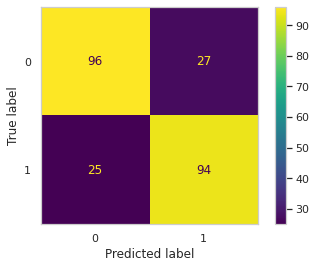

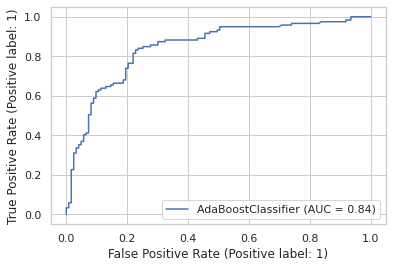

In [84]:
plot_confusion_matrix(adaboost_clf, scaled_data_test, y_test);
plt.grid(False)
find_errors(y_test, adaboost_test_preds)
plot_roc_curve(adaboost_clf, scaled_data_test, y_test);
get_classification_report(y_test, adaboost_test_preds)

#### Interpretation of churn with Adaboost:
* 96 True Negatives: Customers continue service with SyriaTel
* 27 False Positives: The model believes customers will continue service with SyriaTel, but they do not
* 25 False Negatives: The model believes customers  will not continue service with SyriaTel, but they do 
* 94 True Positives: Customers do not continue service with SyriaTel

#### This model performs similarly to some of our earlierr models
#### Our Error calculations are similar to that model as well, but slightly better

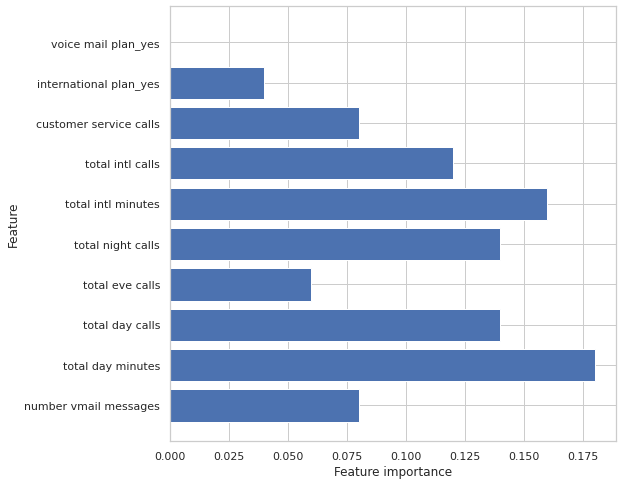

In [85]:
plot_feature_importances(adaboost_clf)

#### GradientBoost

Mean Absolute Error: 0.1652892561983471
Root Mean Squared Error: 0.4065578140908709


,Precision,Recall,F1-score,Support
0,0.837398,0.837398,0.837398,123.000000
1,0.831933,0.831933,0.831933,119.000000
accuracy,0.834711,0.834711,0.834711,0.834711
macro avg,0.834666,0.834666,0.834666,242.000000
weighted avg,0.834711,0.834711,0.834711,242.000000


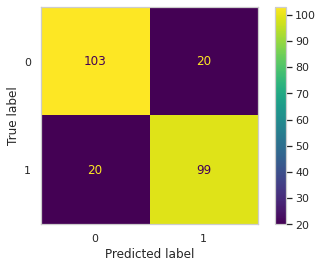

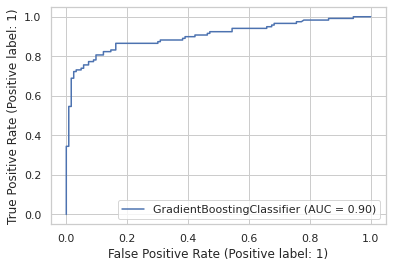

In [86]:
plot_confusion_matrix(gbt_clf, scaled_data_test, y_test);
plt.grid(False)
find_errors(y_test, gbt_clf_test_preds)
plot_roc_curve(gbt_clf, scaled_data_test, y_test);
get_classification_report(y_test, gbt_clf_test_preds)

#### Interpretation of churn with GradientBoost:
* 103 True Negatives: Customers continue service with SyriaTel
* 20 False Positives: The model believes customers will continue service with SyriaTel, but they do not
* 20 False Negatives: The model believes customers  will not continue service with SyriaTel, but they do 
* 99 True Positives: Customers do not continue service with SyriaTel

#### This model performs better than the Adaboost model 
#### This model also has a very high ROC Curve 

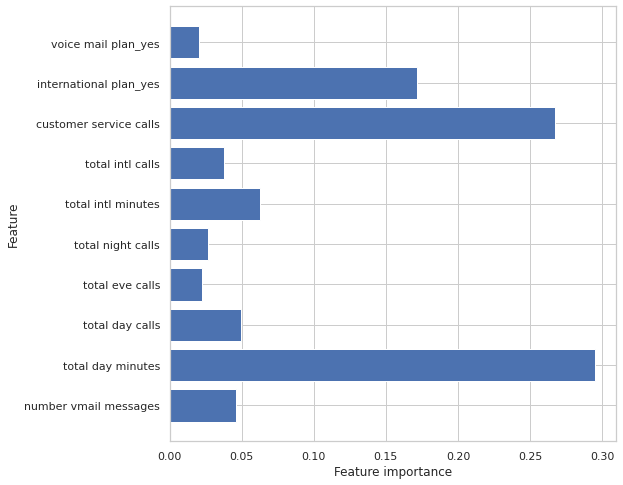

In [87]:
plot_feature_importances(gbt_clf)

In [88]:
# Running a Cross Validation on the entire dataset
print('Mean Adaboost Cross-Val Score (k=5):')
print(cross_val_score(adaboost_clf, X, y, cv=5).mean())

Mean Adaboost Cross-Val Score (k=5):
0.7971048555098553


In [89]:
# Running a Cross Validation on the entire dataset
print('Mean GBT Cross-Val Score (k=5):')
print(cross_val_score(gbt_clf, X, y, cv=5).mean())

Mean GBT Cross-Val Score (k=5):
0.8415950002670798


# Building a VotingClassifier

We will use Scikit learn to determine what is the best model for predicting customer churn with SyriaTel

In [90]:
avg = VotingClassifier(estimators=[
        ('Vanilla Logistic Regression', lr_model),
        ('Tuned Logistic Regression', lr),
        ('Vanilla KNN', v_knn),
        ('Tuned KNN', knn_clf),
        ('Vanilla Tree', vt_clf),
        ('Tuned Tree', dt_clf),
        ('Random Forest', forest),
        ('Tuned Forest', best_forest),
        ('Vannilla SVM', svm_clf),
        ('Tuned SVM', best_svm),
        ('AdaBBoost', adaboost_clf),
        ('GradientBoost', gbt_clf)
    ])

In [91]:
avg.fit(scaled_data_train, y_train)

VotingClassifier(estimators=[('Vanilla Logistic Regression',
                              LogisticRegression(class_weight='balanced',
                                                 random_state=42)),
                             ('Tuned Logistic Regression',
                              LogisticRegression(class_weight={0: 0.3333165829145729,
                                                               1: 0.6666834170854271},
                                                 solver='newton-cg')),
                             ('Vanilla KNN', KNeighborsClassifier()),
                             ('Tuned KNN',
                              KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=21,
                                                   we...
                                                     random_state=42)),
                             ('Random Forest',
                              RandomForestClassifier(max_depth=5)),

In [92]:
# Cross Validation of scores

scores = cross_val_score(estimator=avg, X=scaled_data_train,
                        y=y_train, cv=5)
scores

array([0.86206897, 0.89655172, 0.80689655, 0.82758621, 0.83333333])

In [93]:
np.median(scores)

0.8333333333333334

In [94]:
avg_preds = avg.predict(scaled_data_test)

In [95]:
# Checking the avg scores on the test sets

avg.score(scaled_data_test, y_test)

0.8677685950413223

Mean Absolute Error: 0.1322314049586777
Root Mean Squared Error: 0.36363636363636365


,Precision,Recall,F1-score,Support
0,0.869919,0.869919,0.869919,123.000000
1,0.865546,0.865546,0.865546,119.000000
accuracy,0.867769,0.867769,0.867769,0.867769
macro avg,0.867732,0.867732,0.867732,242.000000
weighted avg,0.867769,0.867769,0.867769,242.000000


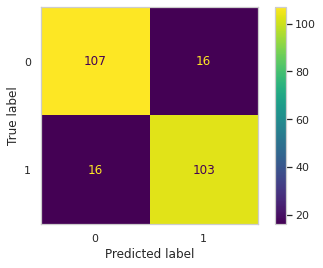

In [96]:
plot_confusion_matrix(avg, scaled_data_test, y_test);
plt.grid(False)
find_errors(y_test, avg_preds)
get_classification_report(y_test, avg_preds)

#### Interpretation of churn with an average `VotingClassifier`:
* 101 True Negatives: Customers continue service with SyriaTel
* 22 False Positives: Model thinks customers will continue service with SyriaTel, but they do not
* 18 False Negatives: Model thinks customers  will not continue service with SyriaTel, but they do 
* 101 True Positives: Customers do not continue service with SyriaTel

#### The Voting Classifier votes nicely, as our False Negatives are very low when compared to some models.
#### Our Error calculations here are also among the lowest reported as well

In [97]:
# Appending relevabnt results to a new df
# metrics_df = metrics_df.append(get_classification_report(y_test, avg_preds).iloc[1:2, :])

# Comparing Models

In [98]:
models = ['Vanilla Logistic Regression', 'Tuned Logistic Regression', 'Vanilla KNN', 
          'Tuned KNN', 'Vanilla Decision Tree', 'Tuned Decision Tree',
          'Vanilla Forest', 'Tuned Forest', 'Vanilla SVM', 'Tuned SVM', 
          'AdaBoost', 'GradientBoost', 'VotingClassifier']

In [99]:
classifiers = [lr_model, lr, v_knn, knn_clf, vt_clf, dt_clf, regressor, forest, best_forest, 
              svm_clf, best_svm, adaboost_clf, gbt_clf, avg]

In [100]:
accuracy_scores = []
f1_scores = []
for model, clf in zip(models, classifiers):
    clf.fit(scaled_data_train, y_train)
    acc_score = clf.score(scaled_data_test, y_test)
    accuracy_scores.append(acc_score)

In [101]:
# Converting our 3-D dataframe into a 2-D dataframe
metrics_df = pd.DataFrame(np.concatenate(metrics_df))

# Renaming our columns, adding a 'Model' column
m_df = metrics_df.set_axis(['Precision', 'Recall', 'F1-score', 'Support'], axis=1, inplace=False)
m_df['Model'] = models

In [102]:
df2 = pd.DataFrame()
df2['Model'] = models
df2['Accuracy Score'] = accuracy_scores
df2 = pd.merge(df2, m_df, on='Model', how='outer')

#### Adding colors to the dataframe for comparisons

In [103]:
cm = sns.light_palette('green', as_cmap=True)
s = df2.style.background_gradient(cmap=cm)
s

,Model,Accuracy Score,Precision,Recall,F1-score,Support
0,Vanilla Logistic Regression,0.776860,0.787611,0.747899,0.767241,119.000000
1,Tuned Logistic Regression,0.694215,0.647059,0.831933,0.727941,119.000000
2,Vanilla KNN,0.851240,0.867257,0.823529,0.844828,119.000000
3,Tuned KNN,0.855372,0.896226,0.798319,0.844444,119.000000
4,Vanilla Decision Tree,0.797521,0.786885,0.806723,0.796680,119.000000
5,Tuned Decision Tree,0.855372,0.838710,0.873950,0.855967,119.000000
6,Vanilla Forest,0.156794,0.851240,0.865546,0.858333,119.000000
7,Tuned Forest,0.859504,0.491736,1.000000,0.659280,119.000000
8,Vanilla SVM,0.859504,0.845528,0.873950,0.859504,119.000000
9,Tuned SVM,0.859504,0.852459,0.873950,0.863071,119.000000


In [104]:
df2.sort_values('Precision', ascending = False)

,Model,Accuracy Score,Precision,Recall,F1-score,Support
3,Tuned KNN,0.855372,0.896226,0.798319,0.844444,119.0
2,Vanilla KNN,0.851240,0.867257,0.823529,0.844828,119.0
12,VotingClassifier,0.834711,0.865546,0.865546,0.865546,119.0
9,Tuned SVM,0.859504,0.852459,0.873950,0.863071,119.0
6,Vanilla Forest,0.156794,0.851240,0.865546,0.858333,119.0
8,Vanilla SVM,0.859504,0.845528,0.873950,0.859504,119.0
5,Tuned Decision Tree,0.855372,0.838710,0.873950,0.855967,119.0
11,GradientBoost,0.785124,0.831933,0.831933,0.831933,119.0
0,Vanilla Logistic Regression,0.776860,0.787611,0.747899,0.767241,119.0
4,Vanilla Decision Tree,0.797521,0.786885,0.806723,0.796680,119.0


In [105]:
df2.sort_values('Recall', ascending = False)

,Model,Accuracy Score,Precision,Recall,F1-score,Support
7,Tuned Forest,0.859504,0.491736,1.000000,0.659280,119.0
5,Tuned Decision Tree,0.855372,0.838710,0.873950,0.855967,119.0
8,Vanilla SVM,0.859504,0.845528,0.873950,0.859504,119.0
9,Tuned SVM,0.859504,0.852459,0.873950,0.863071,119.0
6,Vanilla Forest,0.156794,0.851240,0.865546,0.858333,119.0
12,VotingClassifier,0.834711,0.865546,0.865546,0.865546,119.0
1,Tuned Logistic Regression,0.694215,0.647059,0.831933,0.727941,119.0
11,GradientBoost,0.785124,0.831933,0.831933,0.831933,119.0
2,Vanilla KNN,0.851240,0.867257,0.823529,0.844828,119.0
4,Vanilla Decision Tree,0.797521,0.786885,0.806723,0.796680,119.0


In [106]:
df2.sort_values('F1-score', ascending = False)

,Model,Accuracy Score,Precision,Recall,F1-score,Support
12,VotingClassifier,0.834711,0.865546,0.865546,0.865546,119.0
9,Tuned SVM,0.859504,0.852459,0.873950,0.863071,119.0
8,Vanilla SVM,0.859504,0.845528,0.873950,0.859504,119.0
6,Vanilla Forest,0.156794,0.851240,0.865546,0.858333,119.0
5,Tuned Decision Tree,0.855372,0.838710,0.873950,0.855967,119.0
2,Vanilla KNN,0.851240,0.867257,0.823529,0.844828,119.0
3,Tuned KNN,0.855372,0.896226,0.798319,0.844444,119.0
11,GradientBoost,0.785124,0.831933,0.831933,0.831933,119.0
4,Vanilla Decision Tree,0.797521,0.786885,0.806723,0.796680,119.0
10,AdaBoost,0.863636,0.776860,0.789916,0.783333,119.0


# Conclusions
Overall, most models perform similarly, but only one must be selected.

## Best Model:
### `Tuned SVM`
#### This is because it: 
* Consistently has among the highest Precision, Recall, & F1 scores
* Has excellent MAE & RMSE scores.
* Posesses solid ROC curve, with an AUC of 0.89
* Recieved the lowest number of reported False Positive/Negatives on the confusion matrix

Features: `number vmail messages`, `total day minutes`, `total day calls`, `total eve calls`, `total night calls`, `total intl minutes`, `total intl calls`, `customer service calls`, `international plan_yes`, `voice mail plan_yes`

#### Most important features determining customer churn: `total day minutes`, `customer service calls`, `international plan_yes`
Based on all feature_importances plots

# Recommendations

#### Usage for our model:
* This model is best for predicting whether or not a customer will renew their service with SyriaTel, using the features listed above
* SyriaTel can use this model to help determine ways to retain more customers, including altering their phone plan to acomodate services that are highly viable towards retaining users
* This model will not be useful for predicting the locations of where a user might live, or what the area code of theri phone number might be

#### Suggestions:
* Based on these findings, SyriaTel can benefit by:
    * Offering customers better deals on cell phone minutes & international phone plans
    * Refine the Customer Service experience, so customers are more satisfied
* SyriaTel can modify this model by: 
    * Tuning the parameters on the grid search for this model
    * Include less features for the model to process
    * Use all features from the original dataframe for modeling and see if the Precision, Recall, & F1-scores change.